## Измерение сходства узлов на основе представления графа

В графовых нейронных сетях (Graph Neural Networks, GNN) одним из важных аспектов является измерение сходства между узлами графа.

Node Similarity представляет собой меру близости или похожести между двумя узлами графа. Измерение сходства узлов основывается на их представлениях в графе.
Схожесть узлов (Node Similarity) в графовых сетях представляет собой меру близости или похожести между двумя узлами графа. Измерение сходства узлов основывается на их представлениях в графе. Это понятие играет важную роль в анализе графов, так как позволяет выявлять связи и паттерны между узлами.

Когда речь идет о измерении схожести узлов в графовых сетях, можно использовать различные метрики. Три такие распространенные метрики — это Косинусная схожесть (Cosine Similarity), Манхэттенское расстояние (Manhattan Distance) и Евклидово расстояние (Euclidean Distance).


### Примеры метрик схожести узлов:

**Косинусная схожесть** (Cosine Similarity):


> Измеряет угол между векторами признаков узлов в графе, представляя их как многомерные векторы.

> $Cosine(A, B) = (Σ (A_i * B_i)) / (\sqrt(Σ A_i^2) * \sqrt(Σ B_i^2)), где A_i и B_i$ - значения признаков узлов.

**Манхэттенское расстояние** (Manhattan Distance):

> Измеряет сумму абсолютной разницы между соответствующими координатами узлов на графе.

> $Manh(A, B) = Σ |A_i - B_i|, где A_i и B_i$ - координаты узлов по каждой из размерностей.

**Евклидово расстояние** (Euclidean Distance):


> Измеряет расстояние между двумя узлами в графе, представляя их как точки в пространстве.

> $Euclid(A, B) = sqrt(Σ (A_i - B_i)^2), где A_i и B_i$ - координаты узлов по каждой из размерностей.




Использование этих метрик расстояния позволяет оценить геометрическое расположение узлов в графе.













### Установка зависимостей


Устанавливаем необходимые для работы зависимости

In [1]:
!pip install pykeen networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.3/739.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.0 MB/s eta 0:00:00
  Created wheel for rexmex: filename=rexmex-0.1.3-py3-none-any.whl size=19952 sha256=30fd9656dd3f247158c38ba66fcf08b43732f86d4ba69ecbdfdd3a1d1039d1eb
  Stored in directory: /root/.cache/pip/wheels/13/31/9d/51fb64454e6012bc88dd72b57609646432e478ba35772736d6
Successfully built rexmex


Далее, импортируем необходимых модулей

In [2]:
import torch
import pykeen
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from sklearn.neighbors import NearestNeighbors
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

INFO:pykeen.utils:Using opt_einsum


Здесь мы устанавливаем необходимые библиотеки и импортируем модули, которые будут использоваться в лабораторной работе.

## Взаимодействие с графовым датасетом и описание данных

В данной работе мы будем использовать графовый датасет [DBpedia50](https://arxiv.org/abs/1711.03438), предоставляющий собой выборку менее 50 тысяч сущностей из графа dbpedia.


Мы импортируем модуль datasets из Pykeen для работы с графовыми датасетами.

In [8]:
from pykeen.datasets import PharmKG8k

Загружаем графовый датасет DBpedia50 из Pykeen. В результате выполнения этой команды будет создан объект, представляющий графовый датасет.

In [9]:
# Загрузка графового датасета DBpedia50
dataset = PharmKG8k()

Мы можем вывести описание датасета, чтобы получить информацию о количестве сущностей, отношений и других характеристиках.

In [10]:
# Просмотр описания датасета
print(dataset)

PharmKG8k(training_path="/root/.data/pykeen/datasets/pharmkg8k/train.tsv", testing_path="/root/.data/pykeen/datasets/pharmkg8k/test.tsv", validation_path="/root/.data/pykeen/datasets/pharmkg8k/valid.tsv")


## Обучение модели


Использеум pipeline() предоставляемый пакетом pykeen для обучения модели, в качестве аргументов указываем тип модели, набор данных, количество эпох обучения и устройство на котором проводится обучений

Проверяем наличие GPU устройства и вызываем функцию pipeline(), которая запускает процесс обучения модели, тестирования и валидации.

In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Запускаем пайплайн обучения модели, в этот раз использем модель [ComplEx](https://pykeen.readthedocs.io/en/stable/api/pykeen.models.ComplEx.html)

In [12]:
# Задаем параметры для pipeline
pipeline_results = pipeline(
    model="ComplEx",
    dataset=dataset,
    training_kwargs=dict(num_epochs=100),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 19.05s seconds



В PyKEEN, функция plot_losses используется для визуализации изменения значений функции потерь во времени (по эпохам) в процессе обучения модели. Эта функция часто используется для мониторинга производительности модели во время тренировки и может быть полезной для оценки, насколько хорошо модель учится на обучающем наборе данных.


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

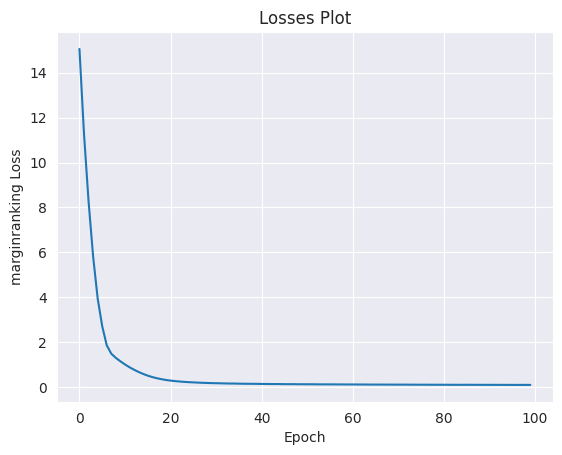

In [13]:
# Обученная модель хранится в pipeline_results
model = pipeline_results.model

#plot loss
pipeline_results.plot_losses()

## Метрики оценки работы модели

В PyKEEN пакет metrics предоставляет реализацию различных метрик, которые могут быть использованы для оценки качества работы моделей знаний (knowledge graph embedding models). Эти метрики позволяют оценивать, насколько хорошо модель справляется с предсказанием троек в графе знаний.

Некоторые из основных метрик, доступных в пакете metrics:

*   Rank-based Metrics - которые измеряют позицию верного ответа (положительной тройки) в отсортированном списке всех возможных троек
*   Top-K Metrics - которые оценивают качество предсказаний в топ-K результатах.
*   Clustering Metrics - которые измеряют качество кластеризации.

Рассчитаем некоторые из них далее.

In [14]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(pipeline_results.model, dataset.testing.mapped_triples,
                             additional_filter_triples=[dataset.training.mapped_triples,
                                                        dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 19.04s seconds


Hits@1: 0.02594244835624146
Hits@3: 0.05851619644723093
Hits@5: 0.08283096214130697
Hits@10: 0.13056627280765212
Mean Reciprocal Rank: 0.06383049488067627


## Получение представлений узлов

После того как модель обучена, мы можем полчить представления узлов и отношений из результатов работы пайплайна.

In [15]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

Мы извлекаем представления узлов из обученной модели. В этом контексте, представления узлов - это векторы, представляющие сущности в графе.


Далее извлечем лейблы для сущнойстей и визуализируем некоторые из сущностей на плоскости.

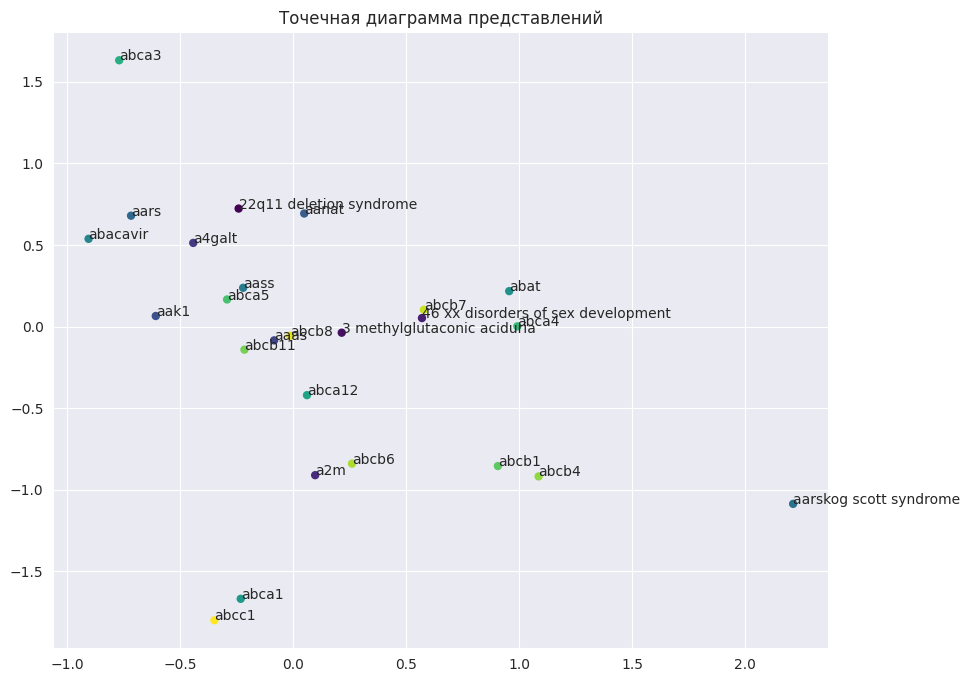

In [16]:
#Созраняем названия сущностей в отдельной переменной
id_to_lable = list(dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

Мы используем NetworkX и Matplotlib для визуализации представлений узлов на графе. Каждая сущность представлена точкой в двумерном пространстве, и близкие точки соответствуют похожим узлам в графе.


## Измерение Node Similarity

Добавим код для измерения близости узлов на основе представлений. Расчитаем близость между несколькими случайными узлами. Используем для этого косинусную схожесть, манхэттенское и евклидово расстояние. Визуализируем полученные результаты как матрицу близости.


[[ 0.       22.790436 22.915718 17.79018 ]
 [22.790436  0.       24.264708 20.191105]
 [22.915718 24.264708  0.       20.131884]
 [17.79018  20.191105 20.131884  0.      ]]


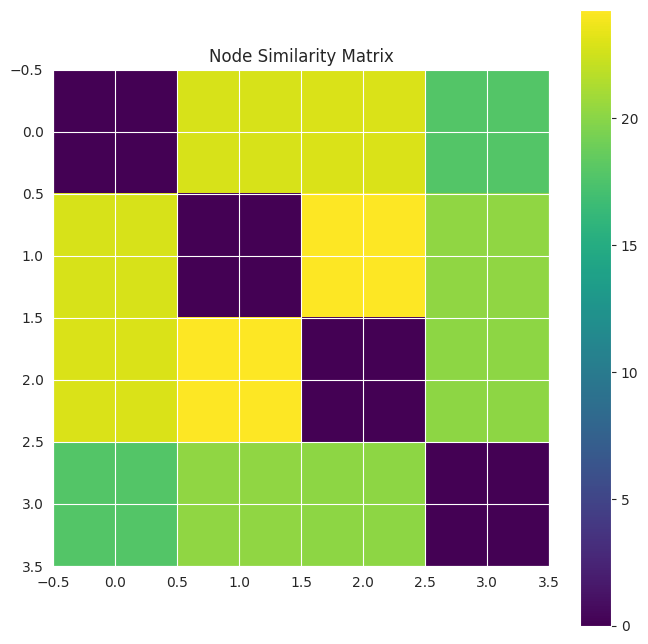

[[ 1.0000002e+00  3.1416178e-02 -3.5286011e-04  5.8532081e-04]
 [ 3.1416178e-02  9.9999952e-01  4.2251911e-02 -3.5713778e-03]
 [-3.5286011e-04  4.2251911e-02  9.9999970e-01 -2.9433208e-02]
 [ 5.8532081e-04 -3.5713778e-03 -2.9433208e-02  1.0000002e+00]]


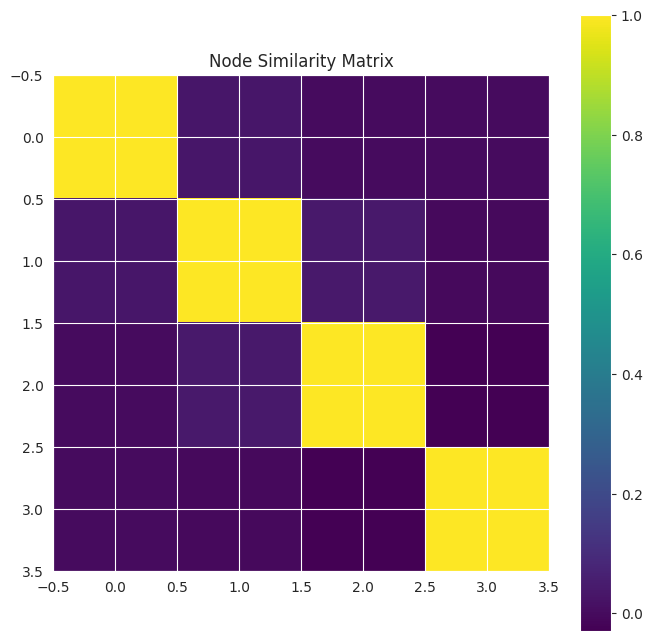

[[  0.         364.80596519 368.92000965 281.04449259]
 [364.80596519   0.         383.33375898 316.62875651]
 [368.92000965 383.33375898   0.         323.76562292]
 [281.04449259 316.62875651 323.76562292   0.        ]]


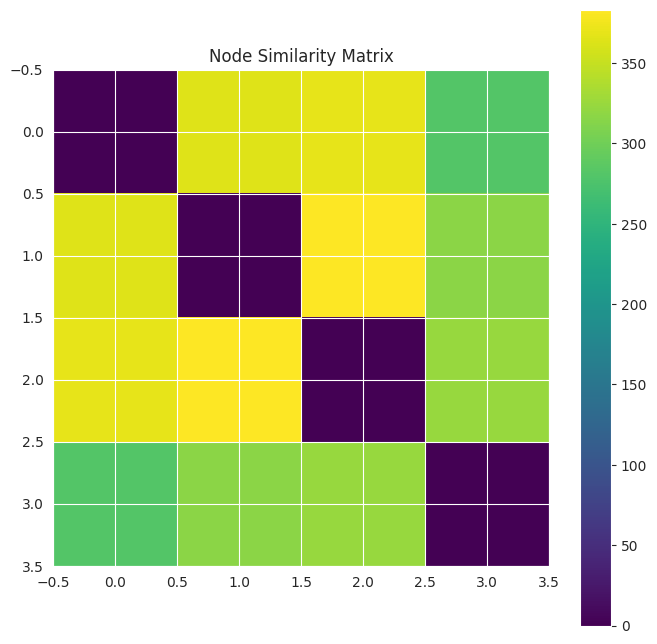

In [18]:
def diplay_matrix(similarity_matrix):
  # Визуализация матрицы близости
  plt.figure(figsize=(8, 8))
  plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title('Node Similarity Matrix')
  plt.show()


# Рассчет близости между узлами
methods = [euclidean_distances,cosine_similarity,manhattan_distances]
#Узлы
nodes = [embedding_numpy[1324],embedding_numpy[6123],embedding_numpy[1234],embedding_numpy[3121]]
for method in methods:
  similarity_matrix = method(nodes)
  print(similarity_matrix)
  diplay_matrix(similarity_matrix)

Этот код использует euclidean_distances,cosine_similarity и manhattan_distances из scikit-learn для вычисления матрицы близости между узлами на основе их представлений. Затем мы визуализируем эту матрицу для наглядного представления Node Similarity.

## Поиск соседей узла
Одной из задач где используется схожесть узлов является задача поиска ближайших соседей конкретного узла в графе.
Рассмотрии применение NearestNeighbors на созданных представлениях с использованием только что рассмотренных методов рассчета близости.

In [19]:
# Выбираем случайный узел
random_node_index = 13
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[3.3717478e-07 1.5420392e+01 1.5462127e+01 1.5475890e+01]]
Индексы:[[  13 1335 1255 5676]]
Ближайшие соседи узла abca1: ['abca1', 'cinalukast', 'chic2', 'rdh8'] 

Метрика:cosine
Дистанции:[[0.         0.76184624 0.78688943 0.78759915]]
Индексы:[[  13 5286 4618 2670]]
Ближайшие соседи узла abca1: ['abca1', 'pon1', 'nlgn3', 'gckr'] 

Метрика:manhattan
Дистанции:[[  0.         251.07603455 251.27825928 252.22691345]]
Индексы:[[  13 1864 1335 7235]]
Ближайшие соседи узла abca1: ['abca1', 'dhrs4', 'cinalukast', 'znf432'] 



In [20]:
# Выбираем случайный узел
random_node_index = 27
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       16.628342 16.654684 16.657967]]
Индексы:[[  27 6465 2845 3763]]
Ближайшие соседи узла abcc3: ['abcc3', 'sulfacytine', 'gpr44', 'levallorphan'] 

Метрика:cosine
Дистанции:[[0.         0.7119487  0.72058094 0.7348995 ]]
Индексы:[[  27   19 6202   24]]
Ближайшие соседи узла abcc3: ['abcc3', 'abcb11', 'slc47a1', 'abcc1'] 

Метрика:manhattan
Дистанции:[[  0.         263.0718689  263.24594116 263.4387207 ]]
Индексы:[[  27 2845 7012 6465]]
Ближайшие соседи узла abcc3: ['abcc3', 'gpr44', 'upf3b', 'sulfacytine'] 



In [21]:
pipeline_results = pipeline(
    model="ComplEx",
    dataset=dataset,
    training_kwargs=dict(num_epochs=10),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 19.03s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

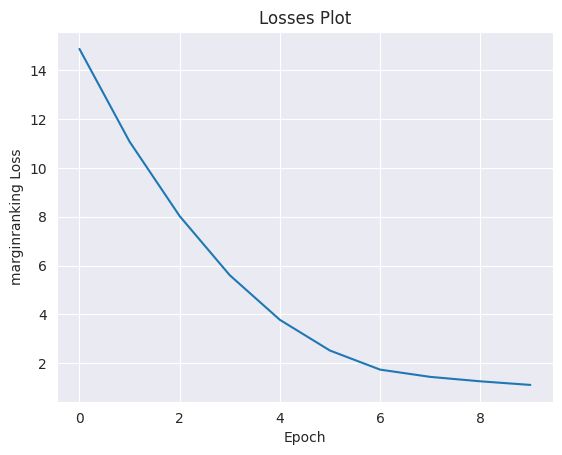

In [22]:
pipeline_results.plot_losses()

In [23]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

model2 = pipeline_results.model
# Оценить работу модели
metrics = evaluator.evaluate(model2, dataset.testing.mapped_triples,
                             additional_filter_triples=[dataset.training.mapped_triples,
                                                        dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 18.97s seconds


Hits@1: 0.010067518688208344
Hits@3: 0.011001929105377381
Hits@5: 0.011755485893416929
Hits@10: 0.013131982959569166
Mean Reciprocal Rank: 0.012091707438230515


In [24]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

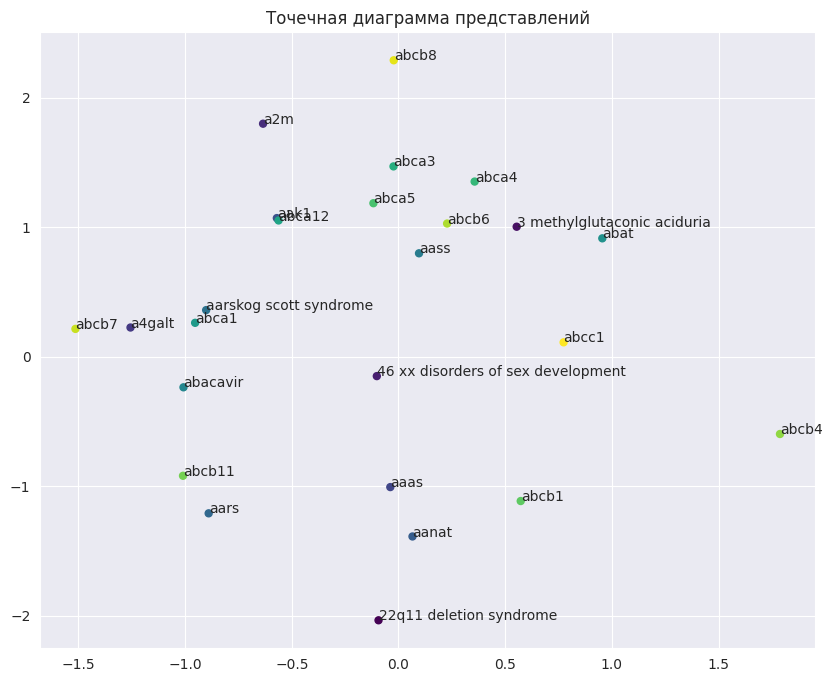

In [25]:
#Сохраняем названия сущностей в отдельной переменной
id_to_lable = list(dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])



In [26]:
# Выбираем случайный узел
random_node_index = 13
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       21.854773 23.216797 23.315624]]
Индексы:[[  13 4521 5710 2408]]
Ближайшие соседи узла abca1: ['abca1', 'neoplasms', 'respiratory tract neoplasms', 'fgf1'] 

Метрика:cosine
Дистанции:[[0.         0.8127576  0.8365567  0.83854294]]
Индексы:[[  13 1792 2498  833]]
Ближайшие соседи узла abca1: ['abca1', 'death', 'fmo3', 'brsk2'] 

Метрика:manhattan
Дистанции:[[  0.         341.76828003 367.46368408 370.05014038]]
Индексы:[[  13 4521 5710 5815]]
Ближайшие соседи узла abca1: ['abca1', 'neoplasms', 'respiratory tract neoplasms', 'ros1'] 



In [27]:
# Еще один узел
random_node_index = 27
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       22.80153  22.815708 24.024654]]
Индексы:[[  27 1868 4521 5707]]
Ближайшие соседи узла abcc3: ['abcc3', 'diabetes mellitus', 'neoplasms', 'respiratory hypersensitivity'] 

Метрика:cosine
Дистанции:[[0.         0.8178581  0.82881755 0.8303399 ]]
Индексы:[[  27 2267 5989   63]]
Ближайшие соседи узла abcc3: ['abcc3', 'etidocaine', 'serpina3', 'accn2'] 

Метрика:manhattan
Дистанции:[[  0.         360.68893433 363.67614746 381.58761597]]
Индексы:[[  27 4521 1868 1050]]
Ближайшие соседи узла abcc3: ['abcc3', 'neoplasms', 'diabetes mellitus', 'ccnd1'] 



In [28]:
pipeline_results = pipeline(
    model="HolE",
    dataset=dataset,
    training_kwargs=dict(num_epochs=50),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=512.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 40.02s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

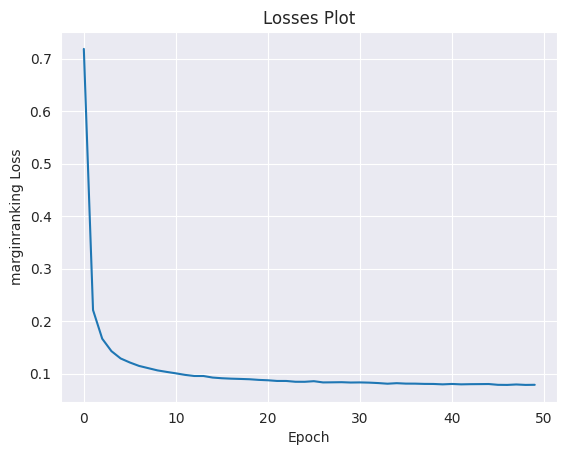

In [29]:
model3 = pipeline_results.model

#plot loss
pipeline_results.plot_losses()

In [30]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()
model3 = pipeline_results.model
# Оценить работу модели
metrics = evaluator.evaluate(model3, dataset.testing.mapped_triples,
                             additional_filter_triples=[dataset.training.mapped_triples,
                                                        dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=512.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 39.80s seconds


Hits@1: 0.03273450687243791
Hits@3: 0.0794148380355277
Hits@5: 0.11032071376898964
Hits@10: 0.16690780483883932
Mean Reciprocal Rank: 0.08009638637304306


In [31]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

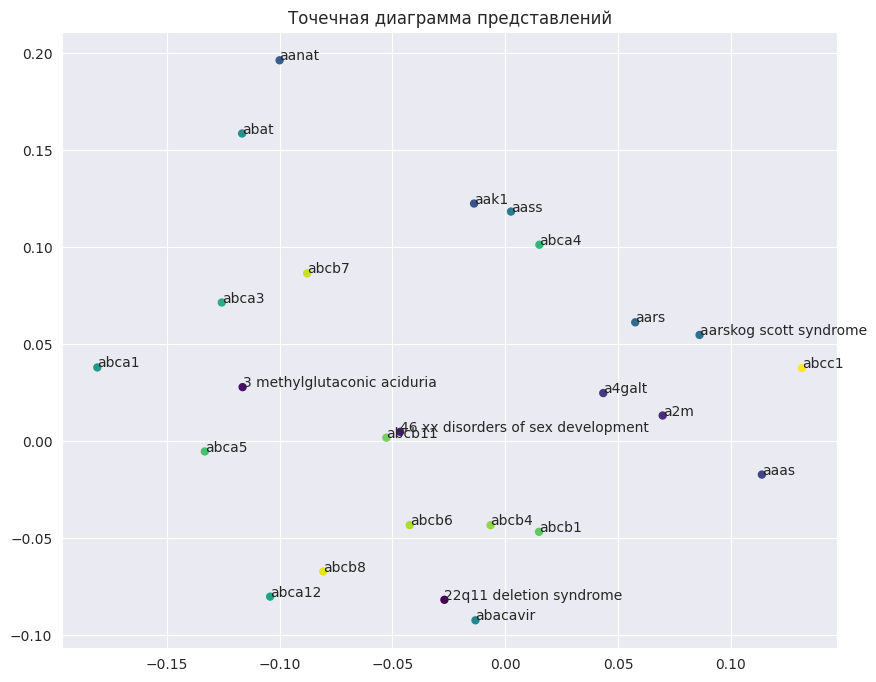

In [32]:
#Созраняем названия сущностей в отдельной переменной
id_to_lable = list(dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

In [33]:
# Выбираем случайный узел
random_node_index = 13
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[0.        1.0373441 1.047816  1.0485013]]
Индексы:[[  13 3864 5308  442]]
Ближайшие соседи узла abca1: ['abca1', 'lpl', 'ppara', 'apoe'] 

Метрика:cosine
Дистанции:[[0.         0.55625796 0.55633795 0.5621003 ]]
Индексы:[[  13 5308  442   20]]
Ближайшие соседи узла abca1: ['abca1', 'ppara', 'apoe', 'abcb4'] 

Метрика:manhattan
Дистанции:[[ 0.         11.62250614 11.76404095 11.80903816]]
Индексы:[[  13 3864 3812 2321]]
Ближайшие соседи узла abca1: ['abca1', 'lpl', 'lipc', 'fabp6'] 



In [34]:
# Еще один узел
random_node_index = 27
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[0.         0.97052306 0.9979298  1.0273057 ]]
Индексы:[[  27   18 6134   19]]
Ближайшие соседи узла abcc3: ['abcc3', 'abcb1', 'slc22a1', 'abcb11'] 

Метрика:cosine
Дистанции:[[5.9604645e-08 4.7095752e-01 5.0159770e-01 5.3433692e-01]]
Индексы:[[  27   18 6134   19]]
Ближайшие соседи узла abcc3: ['abcc3', 'abcb1', 'slc22a1', 'abcb11'] 

Метрика:manhattan
Дистанции:[[ 0.         10.30246735 11.2063427  11.68575287]]
Индексы:[[  27   18 6134 1684]]
Ближайшие соседи узла abcc3: ['abcc3', 'abcb1', 'slc22a1', 'cyp17a1'] 



Этот код использует NearestNeighbors из scikit-learn для поиска ближайших соседей случайного узла в графе. Мы выводим метки ближайших соседей и дистанции до них.

**Node Similarity** и измерение сходства узлов на основе представления являются важными концепциями в графовых нейронных сетях. Эти меры помогают понять структуру графа и выявлять взаимосвязи между узлами. Визуализация представлений узлов может позволить наглядно представить этот процесс и лучше понять, как модель интерпретирует данные в графе.

В рамках этой работы мы рассмотрели что такое Node Similarity как ее рассчитать и как можноиспользовать. Однако, для получения более полного понимания вы можете выполнить следующие задания:

**Исследование влияния числа эпох обучения**
> Измените число эпох обучения в лабораторной работе и оцените, как это влияет на представления узлов и Node Similarity. Добавьте график, отображающий изменение метрики Node Similarity в зависимости от числа эпох.

**Сравнение различных моделей**
> Попробуйте другие модели графовых вложений, такие как HolE или DistMult, и сравните их эффективность в предсказании отношений и измерении Node Similarity.

**Анализ случайных узлов**
> Выберите несколько случайных узлов и проанализируйте их сходство с другими узлами. Обратите внимание на изменения при изменении числа эпох обучения или использовании различных моделей.
